# ANALISI DADES HOSPITALITZACIONS #

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
casos = pd.read_csv("datasets/Vigil_ncia_sindr_mica_d_infeccions_a_Atenci__Prim_ria.csv")
casos_covid = casos[casos['diagnostic'] == 'COVID-19']

vacunacio = pd.read_csv("datasets/vacunacio_excel.csv")
hospital = pd.read_csv("datasets/COVID-19__Persones_hospitalitzades.csv")
uci = pd.read_csv("datasets/COVID-19__Persones_ingressades_en_unitats_de_cr_tics.csv")
defuncions = pd.read_csv("datasets/COVID-19__Defuncions.csv")


print ("Numero total d'instancies: ", hospital.size)
hospital.head()

Numero total d'instancies:  1950945


,setmana_epidemiologica,any,data_inici,data_final,codi_regio,nom_regio,codi_ambit,nom_ambit,codi_abs,nom_abs,sexe,grup_edat,index_socioeconomic,casos,poblacio
0,6,2021,08/02/2021,14/02/2021,75,Barcelona Metropolitana Sud,75,Barcelona Metropolitana Sud,289,L'Hospitalet de Llobregat - 02 Sant Josep,Home,55 a 59,3,1,705
1,14,2021,05/04/2021,11/04/2021,79,Barcelona Ciutat,79,Barcelona Ciutat,69,Barcelona - 09E,Dona,50 a 54,4,1,594
2,52,2021,27/12/2021,02/01/2022,61,Lleida,61,Lleida,139,Lleida - 5 Cappont,Home,80 o més,3,1,237
3,4,2022,24/01/2022,30/01/2022,63,Terres de l'Ebre,63,Terres de l'Ebre,246,Terra Alta,Home,55 a 59,3,1,420
4,11,2022,14/03/2022,20/03/2022,76,Barcelona Metropolitana Nord,76,Barcelona Metropolitana Nord,248,Terrassa - B,Home,70 a 74,4,1,404


In [3]:
print ("Anys Covid: " + str(casos_covid['any'].unique()))
print ("Anys Hospitalitzacions: " + str(hospital['any'].unique()))
print ("Anys Defuncions: " + str(defuncions['any'].unique()))


Anys Covid: [2020 2021 2022]
Anys Hospitalitzacions: [2021 2022 2020]
Anys Defuncions: [2022 2020 2021]


In [4]:
casos_covid = casos_covid[casos_covid['any']>= 2020]
print ("Anys Covid: " + str(casos_covid['any'].unique()))


Anys Covid: [2020 2021 2022]


## Processat dels Datasets
- Inciiarem amb una predicció a tota catalunya i per totes les edats (no separem per regió, edat, sexe i gryp socioeconomic):
    - Eliminar columnes: nom_regio, codi_ambit, nom_ambit, codi_abs, sexe, grup_edat, index_socioeconomic, poblacio
    - Ajuntar files amb mateixa data inici sumant el numero de casos
    - Fer un merging dels datasets utilitzant la columna de data inici com a referencia

In [5]:
casos_covid = casos_covid.drop(columns = ['codi_regio','nom_regio', 'codi_ambit', 'nom_ambit', 'codi_abs', 'nom_abs',
                                         'sexe', 'grup_edat', 'index_socioeconomic', 'poblacio', 'diagnostic'])
hospital = hospital.drop(columns = ['codi_regio','nom_regio', 'codi_ambit', 'nom_ambit', 'codi_abs', 'nom_abs',
                                         'sexe', 'grup_edat', 'index_socioeconomic', 'poblacio', 'setmana_epidemiologica',
                                   'any', 'data_final'])
uci = uci.drop(columns = ['nom_regio', 'codi_regio', 'nom_ambit', 'codi_ambit', 'setmana_epidemiologica',
                                   'any', 'data_final'])

defuncions = defuncions.drop(columns = ['codi_regio','nom_regio', 'codi_ambit', 'nom_ambit', 'sexe', 'grup_edat', 
                                         'index_socioeconomic', 'poblacio', 'setmana_epidemiologica',
                                   'any', 'data_final'])
vacunacio = vacunacio.loc[:82]
vacunacio = vacunacio[['Data', 'Població vacunada amb pauta completa (%)',	'Població vacunada amb dosi addicional (%)']]
vacunacio['Data'] = pd.to_datetime(vacunacio['Data'], format = "%d/%m/%y")
vacunacio = vacunacio.rename(columns = {'Data': 'data_inici', 'Població vacunada amb pauta completa (%)': 'pauta_completa', 
                                        'Població vacunada amb dosi addicional (%)': 'booster'})
vacunacio = vacunacio.sort_values(by=['data_inici'])
vacunacio['pauta_completa'] = vacunacio['pauta_completa']/100
vacunacio['booster'] = vacunacio['booster']/100


In [6]:
casos_covid_agg = casos_covid.groupby(['setmana_epidemiologica', 'any', 'data_inici', 'data_final']).agg('sum').reset_index()
hospital_agg = hospital.groupby(['data_inici']).agg('sum').reset_index()
uci_agg = uci.groupby(['data_inici']).agg('sum').reset_index()
defuncions_agg = defuncions.groupby(['data_inici']).agg('sum').reset_index()

hospital_agg = hospital_agg.rename(columns = {'casos': 'hospitalitzacions'})
uci_agg = uci_agg.rename(columns = {'recompte': 'uci'})
defuncions_agg = defuncions_agg.rename(columns = {'casos': 'defuncions'})

#merged_df = pd.merge(casos_covid_agg, hospital_agg, uci_agg, defuncions_agg , on="data_inici", how="left")

merged_df = pd.merge(pd.merge(pd.merge(casos_covid_agg, hospital_agg, on = 'data_inici', how = 'left'),
                             uci_agg, on = 'data_inici', how = 'left'),
                             defuncions_agg, on = 'data_inici', how = 'left')

merged_df

,setmana_epidemiologica,any,data_inici,data_final,casos,hospitalitzacions,uci,defuncions
0,1,2020,30/12/2019,05/01/2020,79,NaN,NaN,NaN
1,1,2021,04/01/2021,10/01/2021,29476,2423.0,470.0,385.0
2,1,2022,03/01/2022,09/01/2022,164650,2258.0,498.0,205.0
3,2,2020,06/01/2020,12/01/2020,74,NaN,NaN,NaN
4,2,2021,11/01/2021,17/01/2021,34189,2832.0,550.0,495.0
...,...,...,...,...,...,...,...,...
152,51,2022,19/12/2022,25/12/2022,4769,719.0,NaN,NaN
153,52,2020,21/12/2020,27/12/2020,19359,1784.0,338.0,281.0
154,52,2021,27/12/2021,02/01/2022,153271,1769.0,452.0,177.0
155,52,2022,26/12/2022,01/01/2023,3024,NaN,NaN,NaN


In [7]:
merged_df = merged_df.fillna(0)

print (merged_df.dtypes)
merged_df['data_inici'] = pd.to_datetime(merged_df['data_inici'], format = "%d/%m/%Y")
merged_df['data_final'] = pd.to_datetime(merged_df['data_final'], format = "%d/%m/%Y")
merged_df['hospitalitzacions'] = merged_df['hospitalitzacions'].astype(int)
merged_df['uci'] = merged_df['uci'].astype(int)
merged_df['defuncions'] = merged_df['defuncions'].astype(int)

print()
print ('AFTER TRANSFORMATION')
print()
print(merged_df.dtypes)


setmana_epidemiologica      int64
any                         int64
data_inici                 object
data_final                 object
casos                       int64
hospitalitzacions         float64
uci                       float64
defuncions                float64
dtype: object

AFTER TRANSFORMATION

setmana_epidemiologica             int64
any                                int64
data_inici                datetime64[ns]
data_final                datetime64[ns]
casos                              int64
hospitalitzacions                  int64
uci                                int64
defuncions                         int64
dtype: object


In [8]:
merged_df = merged_df.sort_values(by=['data_inici'])
vacunacio = vacunacio.sort_values(by=['data_inici'])

merged_df = pd.merge_asof(merged_df, vacunacio, on='data_inici', tolerance=pd.Timedelta('2d'), direction = 'nearest')

merged_df.loc[merged_df['data_inici']<=datetime.datetime(2020,12,21), 'pauta_completa'] = 0
merged_df.loc[merged_df['data_inici']<=datetime.datetime(2020,12,21), 'booster'] = 0
merged_df

,setmana_epidemiologica,any,data_inici,data_final,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster
0,1,2020,2019-12-30,2020-01-05,79,0,0,0,0.0,0.0
1,2,2020,2020-01-06,2020-01-12,74,0,0,0,0.0,0.0
2,3,2020,2020-01-13,2020-01-19,50,0,0,0,0.0,0.0
3,4,2020,2020-01-20,2020-01-26,57,0,0,0,0.0,0.0
4,5,2020,2020-01-27,2020-02-02,133,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
152,48,2022,2022-11-28,2022-12-04,9919,900,0,0,NaN,NaN
153,49,2022,2022-12-05,2022-12-11,6882,994,0,0,NaN,NaN
154,50,2022,2022-12-12,2022-12-18,6657,930,0,0,NaN,NaN
155,51,2022,2022-12-19,2022-12-25,4769,719,0,0,NaN,NaN


In [9]:

merged_df = merged_df.sort_values(by=['data_inici'])
merged_df.to_csv('datasets/training_dataset.csv')
merged_df

,setmana_epidemiologica,any,data_inici,data_final,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster
0,1,2020,2019-12-30,2020-01-05,79,0,0,0,0.0,0.0
1,2,2020,2020-01-06,2020-01-12,74,0,0,0,0.0,0.0
2,3,2020,2020-01-13,2020-01-19,50,0,0,0,0.0,0.0
3,4,2020,2020-01-20,2020-01-26,57,0,0,0,0.0,0.0
4,5,2020,2020-01-27,2020-02-02,133,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
152,48,2022,2022-11-28,2022-12-04,9919,900,0,0,NaN,NaN
153,49,2022,2022-12-05,2022-12-11,6882,994,0,0,NaN,NaN
154,50,2022,2022-12-12,2022-12-18,6657,930,0,0,NaN,NaN
155,51,2022,2022-12-19,2022-12-25,4769,719,0,0,NaN,NaN


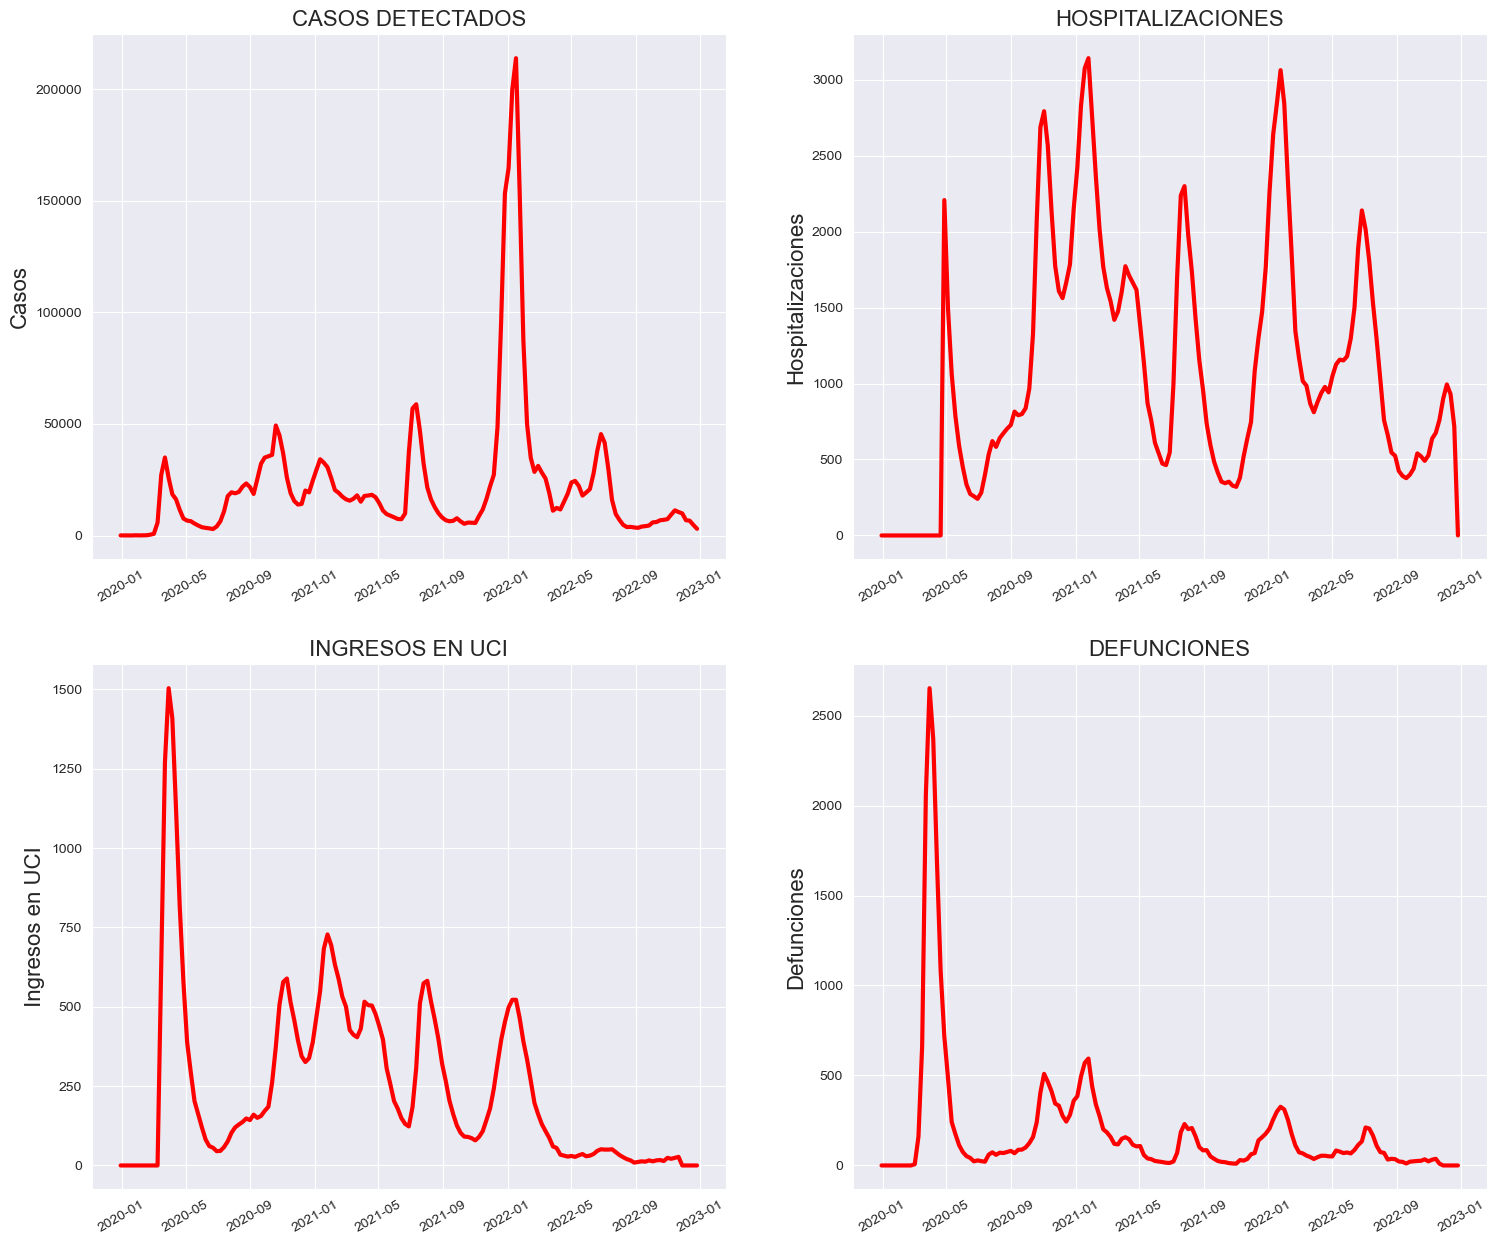

In [10]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(18, 15), sharey=False)
#sns.despine(left=True)
sns.set(font_scale=0.60) 
sns.set_context("poster")

sns.lineplot (ax = axes[0,0], data = merged_df, x = 'data_inici', y = 'casos', color = 'red')
axes[0,0].set_title('CASOS DETECTADOS', fontsize=16)
axes[0,0].set_xlabel('', fontsize=10);
axes[0,0].set_ylabel('Casos', fontsize=16);

sns.lineplot (ax = axes[0,1], data = merged_df, x = 'data_inici', y = 'hospitalitzacions', color = 'red')
axes[0,1].set_title('HOSPITALIZACIONES', fontsize = 16)
axes[0,1].set_xlabel('', fontsize=10);
axes[0,1].set_ylabel('Hospitalizaciones', fontsize=16);

sns.lineplot (ax = axes[1,0], data = merged_df, x = 'data_inici', y = 'uci', color = 'red')
axes[1,0].set_title('INGRESOS EN UCI', fontsize = 16)
axes[1,0].set_xlabel('', fontsize=10);
axes[1,0].set_ylabel('Ingresos en UCI', fontsize=16);

sns.lineplot (ax = axes[1,1], data = merged_df, x = 'data_inici', y = 'defuncions', color = 'red')
axes[1,1].set_title('DEFUNCIONES', fontsize = 16)
axes[1,1].set_xlabel('', fontsize=10);
axes[1,1].set_ylabel('Defunciones', fontsize=16);

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30)


## Correlation study between the data

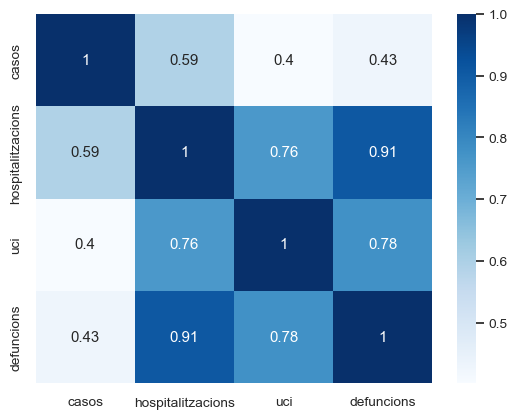

In [11]:
sns.set(font_scale = 0.9)
dataset_training = merged_df[merged_df['any']>=2021]
corr_df = dataset_training.drop(columns = ['setmana_epidemiologica', 'any', 'data_inici', 'data_final', 'pauta_completa', 'booster'])

sns.heatmap(corr_df.corr(), annot=True, cmap = 'Blues');


### We know that cases in one week cause hospitalizations, icu and deaths in following weeks, so let's see between which weeks there is higher correlation

<Axes: >

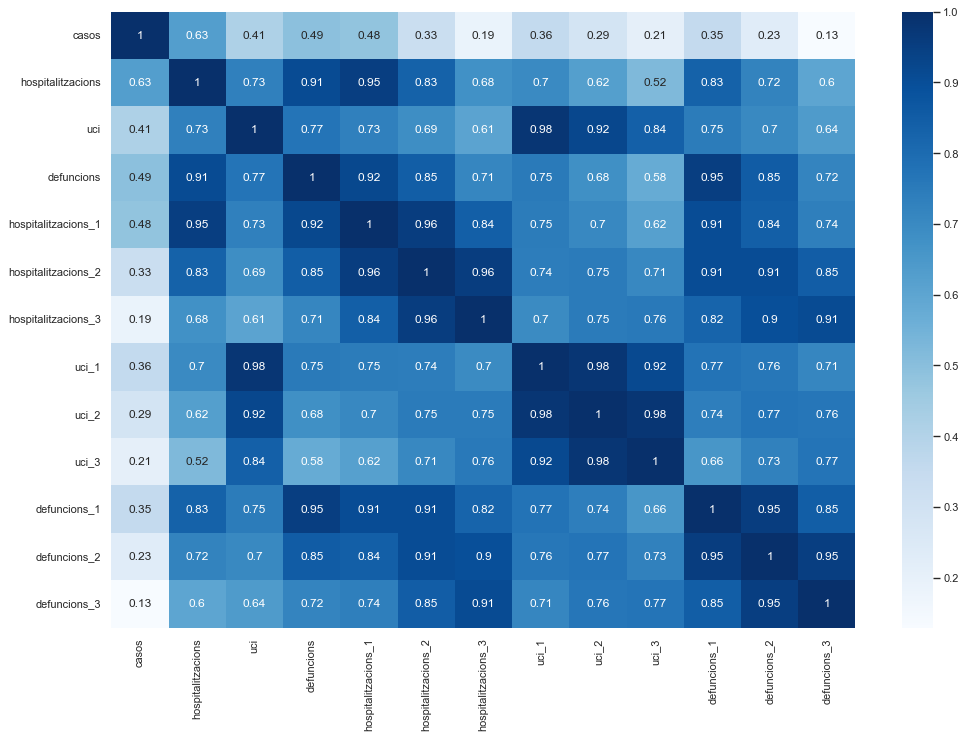

In [12]:
shift_df = corr_df.copy()

shift_df['hospitalitzacions_1'] = shift_df['hospitalitzacions'].shift(1, fill_value = 0)
shift_df['hospitalitzacions_2'] = shift_df['hospitalitzacions'].shift(2, fill_value = 0)
shift_df['hospitalitzacions_3'] = shift_df['hospitalitzacions'].shift(3, fill_value = 0)

shift_df['uci_1'] = shift_df['uci'].shift(1, fill_value = 0)
shift_df['uci_2'] = shift_df['uci'].shift(2, fill_value = 0)
shift_df['uci_3'] = shift_df['uci'].shift(3, fill_value = 0)

shift_df['defuncions_1'] = shift_df['defuncions'].shift(1, fill_value = 0)
shift_df['defuncions_2'] = shift_df['defuncions'].shift(2, fill_value = 0)
shift_df['defuncions_3'] = shift_df['defuncions'].shift(3, fill_value = 0)

shift_df = shift_df.iloc[3: , :]
plt.figure(figsize=(15, 10), dpi=80)
sns.heatmap(shift_df.corr(), annot=True, cmap = 'Blues')




#### Conclusions de l'evolució en salts entre casos - hospitalizacions - uci - defuncions en varies setmanes
- Casos:
    - Hospitalitzacions mateixa setmana (0.85)
    - Uci mateixa setmana (0.86)
    - Defuncions mateixa setmana (0.85)
    
- Hospitalitzacions:
    - Uci mateixa setmana (0.75)
    - Defuncions mateixa setmana (0.93)
    
- Uci:
    - Defuncions en una setmana (0.85)

# First Simple Implementations of Forecasting Models

### First Model: Simple fNN with just 

cases for Forecasting of Cases
Make predictions based on the data of the past 5 weeks

In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

dataset_training = merged_df[merged_df['any']>=2021]

simple_df = dataset_training[['casos']]
simple_df = (simple_df-simple_df.min())/(simple_df.max()-simple_df.min())


#We create the columns with the values of the previous weeks --> attributes
simple_df['cases-1'] = simple_df['casos'].shift(1)
simple_df['cases-2'] = simple_df['casos'].shift(2)
simple_df['cases-3'] = simple_df['casos'].shift(3)
simple_df['cases-4'] = simple_df['casos'].shift(4)
simple_df['cases-5'] = simple_df['casos'].shift(5)

#We create the target column with the predictions for next week
simple_df['target'] = simple_df['casos'].shift(-1)

simple_df = simple_df.iloc[5:,:]
simple_df = simple_df.iloc[:-1, :]
simple_df

,casos,cases-1,cases-2,cases-3,cases-4,cases-5,target
58,0.082380,0.107829,0.130740,0.140510,0.147804,0.125452,0.076541
59,0.076541,0.082380,0.107829,0.130740,0.140510,0.147804,0.068436
60,0.068436,0.076541,0.082380,0.107829,0.130740,0.140510,0.062707
61,0.062707,0.068436,0.076541,0.082380,0.107829,0.130740,0.059819
62,0.059819,0.062707,0.068436,0.076541,0.082380,0.107829,0.063841
...,...,...,...,...,...,...,...
151,0.035684,0.039255,0.030163,0.020612,0.019108,0.018164,0.032701
152,0.032701,0.035684,0.039255,0.030163,0.020612,0.019108,0.018297
153,0.018297,0.032701,0.035684,0.039255,0.030163,0.020612,0.017230
154,0.017230,0.018297,0.032701,0.035684,0.039255,0.030163,0.008276


In [42]:
#Creating X and Y data loaders
X_df = simple_df.drop(columns = ['target'])
y_df = simple_df[['target']]

X = X_df.values
y = y_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'Training Values: {X_train.shape}')
print(f'Testing Values: {X_test.shape}')


Training Values: (78, 6)
Testing Values: (20, 6)


In [70]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Define a feed forward neural network with a regression output
n_neurons_per_hidden_layer = [2000, 1000, 500, 100, 25]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(6,1)))
for neurons in n_neurons_per_hidden_layer:
  model.add(tf.keras.layers.Dense(neurons, activation="elu", kernel_initializer = "he_normal", 
            kernel_regularizer=tf.keras.regularizers.l1(0.001)))
  model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation="linear")) #output linear layer

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 6)                 0         
                                                                 
 dense_32 (Dense)            (None, 2000)              14000     
                                                                 
 batch_normalization_27 (Bat  (None, 2000)             8000      
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 1000)              2001000   
                                                                 
 batch_normalization_28 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 500)              

Epoch 1/100


2024-01-05 18:06:31.382630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 434ms/step - loss: 80.7996 - mean_absolute_error: 0.9516
Epoch 2/100
4/4 [==============================] - 1s 195ms/step - loss: 78.7345 - mean_absolute_error: 0.3213
Epoch 3/100
4/4 [==============================] - 1s 163ms/step - loss: 78.0073 - mean_absolute_error: 0.1793
Epoch 4/100
4/4 [==============================] - 0s 80ms/step - loss: 77.1783 - mean_absolute_error: 0.2164
Epoch 5/100
4/4 [==============================] - 0s 99ms/step - loss: 76.1123 - mean_absolute_error: 0.1485
Epoch 6/100
4/4 [==============================] - 0s 75ms/step - loss: 74.9257 - mean_absolute_error: 0.1228
Epoch 7/100
4/4 [==============================] - 0s 65ms/step - loss: 73.6227 - mean_absolute_error: 0.1070
Epoch 8/100
4/4 [==============================] - 0s 47ms/step - loss: 72.2553 - mean_absolute_error: 0.1274
Epoch 9/100
4/4 [==============================] - 0s 55ms/step - loss: 70.8102 - mean_absolute_error: 0.1047
Epoch 10/100
4/4 [=

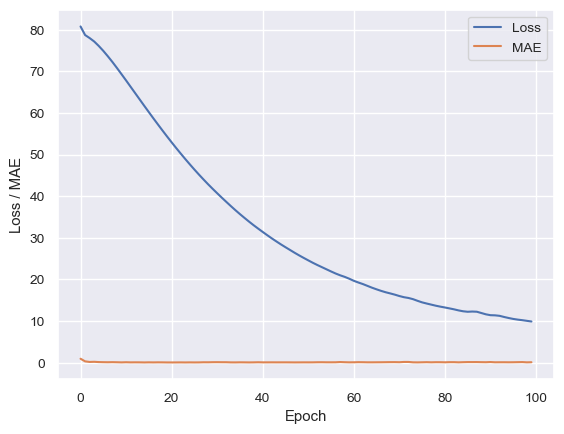

2024-01-05 18:06:52.364292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 651ms/step - loss: 9.7662 - mean_absolute_error: 0.0576
Loss Value Test: 9.766196250915527
MAE Test: 0.05760163813829422


In [58]:
# train the model

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['MeanAbsoluteError'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=20)

loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.legend(['Loss', 'MAE'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model.evaluate(X_test, y_test)
print("Loss Value Test: " + str(loss))
print("MAE Test: " + str(mean_absolute_error))

2024-01-05 18:06:53.011815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 486ms/step


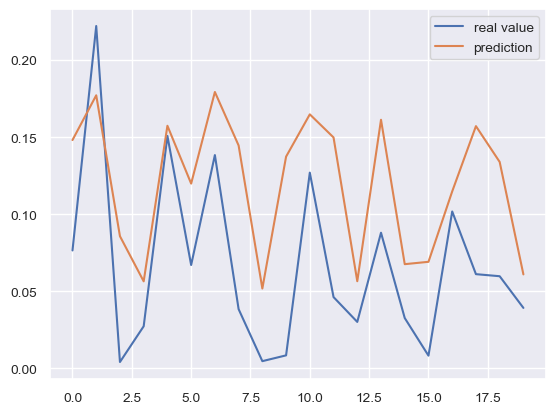

Mean Absolute Error:  0.05760164006717032


In [59]:
y_pred = model.predict(X_test)

plt.plot(y_test, label = 'real value')
plt.plot(y_pred, label = 'prediction')
plt.legend()
plt.show()
print("Mean Absolute Error: " , np.mean(abs(y_test - y_pred)))

### More Complex Model Including Mobility restrictions, Holidays, Mean Temperature of the week, Mask Policy

In [61]:
import calendar
import datetime
import holidays

dataset_training = merged_df[merged_df['any']>=2021]

#dies de festa ja que pot afectar al numero de tests
holidays_v = []
for day in dataset_training.data_inici:
    holidays_d = 0
    for i in range(7):
        if ((day + datetime.timedelta(days=i)) in holidays.Spain()) == True:
            holidays_d+=1
    holidays_v.append(holidays_d)
    holidays_d = 0

dataset_training['holidays'] = holidays_v

#hi havia toc de queda en aquelles dates?
toc_queda = []
for day in dataset_training.data_inici:
  if datetime.datetime(2021, 1, 1) < day and day < datetime.datetime(2021, 5, 7):
    toc_queda.append(1)
  elif datetime.datetime(2021, 7, 15) < day and day < datetime.datetime(2021, 8, 24):
    toc_queda.append(1)
  elif datetime.datetime(2021, 12, 24) < day and day < datetime.datetime(2022, 1, 21):
    toc_queda.append(1)
  else:
    toc_queda.append(0)

dataset_training['toc_queda'] = toc_queda

#hi havia obligatorietat de mascareta?
mascareta = []
for day in dataset_training.data_inici:
  if datetime.datetime(2021, 1, 1) < day and day < datetime.datetime(2022, 4, 20):
    mascareta.append(1)
  else:
    mascareta.append(0)

dataset_training['mascareta'] = mascareta

#quina era la temperatura mitjana en aquell mes?
temp_month = [11.8, 12.4, 14.2, 15.8, 19.3, 23.0, 25.7, 26.1, 23.0, 19.5, 14.9, 12.3]
temp = []
for day in dataset_training.data_inici:
  temp.append(temp_month[day.month-1])

dataset_training['temperature'] = temp

dataset_training.to_csv('datasets/training_dataset_complete.csv')
dataset_training.head()


/var/folders/v7/n70jpygd74d0y1kxzrd_w5y00000gn/T/ipykernel_6735/1369662256.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_training['holidays'] = holidays_v
/var/folders/v7/n70jpygd74d0y1kxzrd_w5y00000gn/T/ipykernel_6735/1369662256.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_training['toc_queda'] = toc_queda
/var/folders/v7/n70jpygd74d0y1kxzrd_w5y00000gn/T/ipykernel_6735/1369662256.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,setmana_epidemiologica,any,data_inici,data_final,casos,hospitalitzacions,uci,defuncions,pauta_completa,booster,holidays,toc_queda,mascareta,temperature
53,1,2021,2021-01-04,2021-01-10,29476,2423,470,385,0.0000,0.0,1,1,1,11.8
54,2,2021,2021-01-11,2021-01-17,34189,2832,550,495,0.0000,0.0,0,1,1,11.8
55,3,2021,2021-01-18,2021-01-24,32651,3075,683,570,0.0000,0.0,0,1,1,11.8
56,4,2021,2021-01-25,2021-01-31,30591,3141,728,594,0.0010,0.0,0,1,1,11.8
57,5,2021,2021-02-01,2021-02-07,25760,2751,694,440,0.0082,0.0,0,1,1,12.4


In [65]:
simple_df = dataset_training[['data_inici', 'casos', 'holidays', 'toc_queda', 'mascareta', 'temperature']]
max_casos = simple_df.casos.max()
min_casos = simple_df.casos.min()

# El test es fa en la sisena onada, durant les dates 30/05/2022 - 19/09/2022
index1 = simple_df.index[simple_df['data_inici'] == datetime.datetime(2022, 5, 30)]
index2 = simple_df.index[simple_df['data_inici'] == datetime.datetime(2022, 9, 19)]
simple_df.drop(columns = ['data_inici'])

simple_df = (simple_df-simple_df.min())/(simple_df.max()-simple_df.min())


#We create the columns with the values of the previous weeks --> attributes
simple_df['cases-1'] = simple_df['casos'].shift(1)
simple_df['cases-2'] = simple_df['casos'].shift(2)
simple_df['cases-3'] = simple_df['casos'].shift(3)
simple_df['cases-4'] = simple_df['casos'].shift(4)
simple_df['cases-5'] = simple_df['casos'].shift(5)

#We create the target column with the predictions for next week
simple_df['target'] = simple_df['casos'].shift(-1)

simple_df = simple_df.iloc[5:,:]
simple_df = simple_df.iloc[:-1, :]

# eliminate the date column
simple_df = simple_df.drop(columns = 'data_inici')

simple_df.head()

,casos,holidays,toc_queda,mascareta,temperature,cases-1,cases-2,cases-3,cases-4,cases-5,target
58,0.08238,0.0,1.0,1.0,0.041958,0.107829,0.13074,0.14051,0.147804,0.125452,0.076541
59,0.076541,0.0,1.0,1.0,0.041958,0.08238,0.107829,0.13074,0.14051,0.147804,0.068436
60,0.068436,0.0,1.0,1.0,0.041958,0.076541,0.08238,0.107829,0.13074,0.14051,0.062707
61,0.062707,0.0,1.0,1.0,0.167832,0.068436,0.076541,0.08238,0.107829,0.13074,0.059819
62,0.059819,0.0,1.0,1.0,0.167832,0.062707,0.068436,0.076541,0.08238,0.107829,0.063841


In [67]:
#Creating X and Y data loaders

Test_df = simple_df.loc[index1[0]:index2[0]]
Training_df = simple_df.drop(simple_df.index[index1[0]:index2[0]])

X_train = Training_df.drop(columns = ['target']).values.astype(np.float32)
X_test = Test_df.drop(columns = ['target']).values.astype(np.float32)

y_train = Training_df[['target']].values.astype(np.float32)
y_test = Test_df[['target']].values.astype(np.float32)

print(f'Training Values: {X_train.shape}')
print(f'Testing Values: {X_test.shape}')


Training Values: (98, 10)
Testing Values: (17, 10)


Epoch 1/150


2024-01-05 18:28:05.869194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 426ms/step - loss: 26.6504 - mean_absolute_error: 0.9628
Epoch 2/150
5/5 [==============================] - 1s 202ms/step - loss: 25.2155 - mean_absolute_error: 0.5026
Epoch 3/150
5/5 [==============================] - 1s 142ms/step - loss: 24.8179 - mean_absolute_error: 0.2441
Epoch 4/150
5/5 [==============================] - 1s 112ms/step - loss: 24.5795 - mean_absolute_error: 0.2396
Epoch 5/150
5/5 [==============================] - 0s 79ms/step - loss: 24.2919 - mean_absolute_error: 0.1823
Epoch 6/150
5/5 [==============================] - 0s 91ms/step - loss: 23.9588 - mean_absolute_error: 0.1305
Epoch 7/150
5/5 [==============================] - 0s 52ms/step - loss: 23.6438 - mean_absolute_error: 0.1677
Epoch 8/150
5/5 [==============================] - 0s 38ms/step - loss: 23.2617 - mean_absolute_error: 0.1117
Epoch 9/150
5/5 [==============================] - 0s 37ms/step - loss: 22.8804 - mean_absolute_error: 0.1046
Epoch 10/150
5/5 [

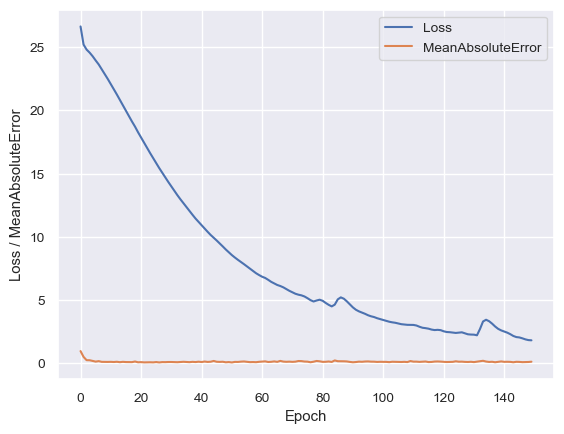

2024-01-05 18:28:35.183427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 785ms/step - loss: 1.7813 - mean_absolute_error: 0.0672
Loss Value Test: 1.7812511920928955
MeanAbsoluteError Test: 17185.852668829262


In [81]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# Define the Feed Forward Neural Network model
n_neurons_per_hidden_layer = [1000, 500, 100, 25]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(10,1)))
for neurons in n_neurons_per_hidden_layer:
  model.add(tf.keras.layers.Dense(neurons, activation="elu", kernel_initializer = "he_normal", 
            kernel_regularizer=tf.keras.regularizers.l1(0.001)))
  model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation="linear")) #output linear layer


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=150, batch_size=20)
loss = history.history['loss']
mae = history.history['mean_absolute_error']

plt.plot(loss)
plt.plot(mae)
plt.xlabel('Epoch')
plt.ylabel('Loss / MeanAbsoluteError')
plt.legend(['Loss', 'MeanAbsoluteError'])
plt.show()


# Make predictions on the test data
loss, mean_absolute_error = model.evaluate(X_test, y_test)
print("Loss Value Test: " + str(loss))
print("MeanAbsoluteError Test: " + str(mean_absolute_error*(max_casos-min_casos)+min_casos))


2024-01-05 18:28:41.525051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 422ms/step
Mean Absolute Error:  17185.85155990413


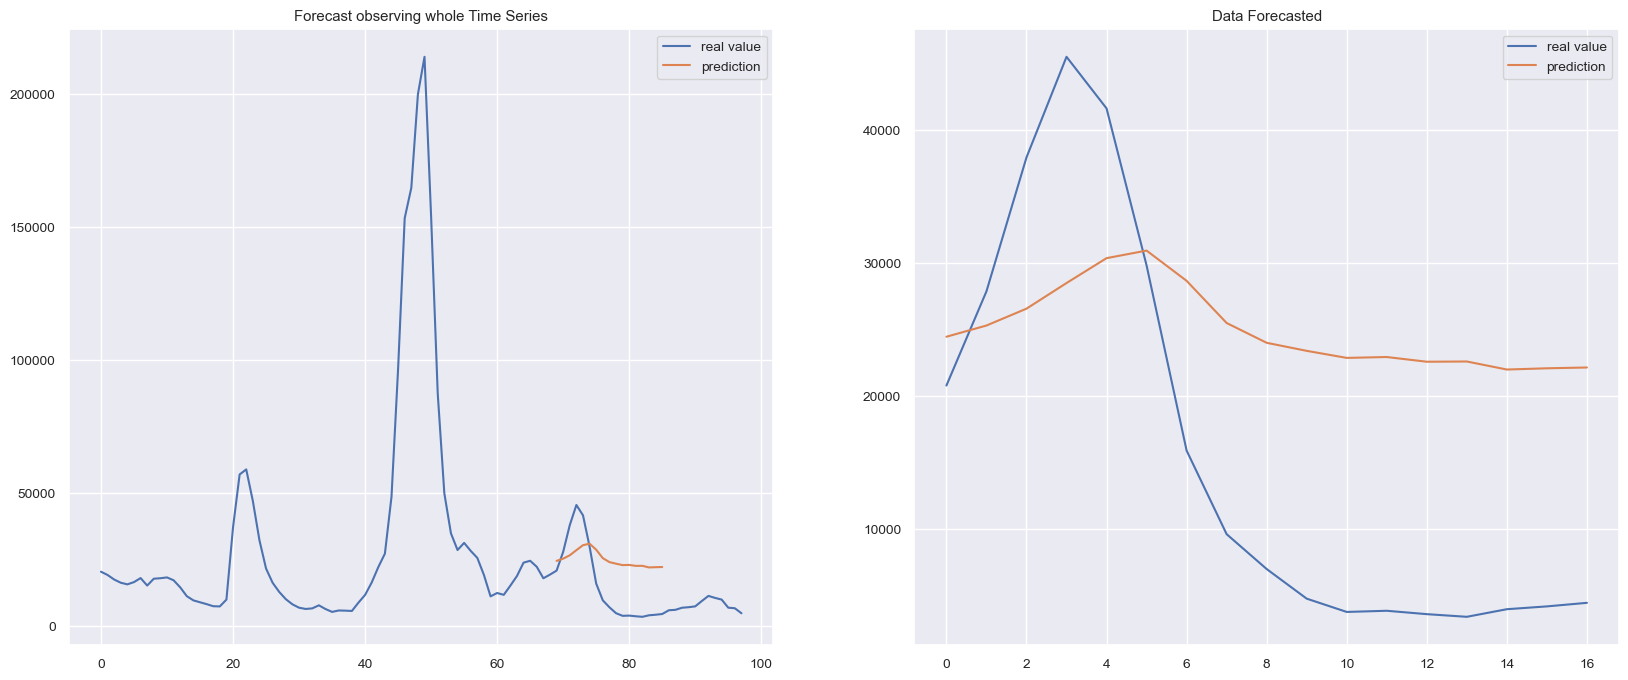

In [82]:
#create the prediction
y_pred = model.predict(X_test)

fig, axs = plt.subplots(1, 2, figsize = (20, 8))
#plt.plot(y_test*(max_casos-min_casos)+min_casos, label = 'real value')
axs[0].plot(np.arange(0, len(simple_df)), simple_df['casos']*(max_casos-min_casos)+min_casos, label = 'real value')
start_index = np.where(simple_df['casos'].values.astype(np.float32) == y_test[0][0])
axs[0].plot(np.arange(start_index[0][0], len(y_pred)+start_index[0][0]), y_pred*(max_casos-min_casos)+min_casos, label = 'prediction')
axs[0].legend()
axs[0].set_title("Forecast observing whole Time Series")

axs[1].plot(y_test*(max_casos-min_casos)+min_casos, label = 'real value')
axs[1].plot(y_pred*(max_casos-min_casos)+min_casos, label = 'prediction')
axs[1].legend()
axs[1].set_title("Data Forecasted")
print("Mean Absolute Error: " , np.mean(abs(y_test - y_pred)*(max_casos-min_casos)+min_casos))